 The optimization package of Qiskit is mainly for QUBO, or general quadratic problems. However, as we are dealing with max-4-cut, we have terms upto order 4. It seems that we need to implement the QAOA algorithm on a circuit level, unless there are other packages unknown to us.

Please put reusable functions into python files and keep the minimum amount of code in this notebook. <br>
Thanks to Jakob and Franziska, now we have a sample data to work on with. I (Kevin) suggest that we follow a similar structure as 'https://qiskit.org/textbook/ch-applications/qaoa.html'. 
1. Use brute force to compute the costs for all combinations and find the optimal cost. This will be used for   scoring the performance of our QAOA implementation.
2. Construct the mixing hamiltonian and problem Hamiltonian gate by gate and draw out the circuit diagrams. (For this refer to Jezer's document)
3. Assemble the circuit and draw the circuit diagram
4. Run classical optimization. (I think Qiskit has a few built-in classical optimizers that we can use.)
5. Evaluate the results, and check the performance for different problem sizes and circuit depth.

In [1]:
from data_processing import *
from Max_k_cut_functions import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [2]:
# Set parameters here

p = 3  # the depth of QAOA

l = 2  # the number of qubits for each node, k = 2^l where k is the number of subgraphs we'd like to cut, 
       # or to say, the k in 'max-k-cut'. l = 2 for a max-4-cut example 
    
n_imp = 3  # the number of important nodes, or to say the nodes with which the associated edges have larger weights

n_unimp = 2  # the number of less important nodes ... smaller weights

nshots = 512  # the number of shots per iteration

init_params = [np.pi/8, np.pi]*p  # the initial parameters gammas and betas. This is however unused in the full
                                  # optimization loop since the educated global guess optimization does not require
                                  # initial guesses. The init_params here will be used later to demonstrate the 
                                  # performance of a local optimzation alone.

local_optimization_method = 'Nelder-Mead'  # the local optimization algorithm to be used, supported by Scipy. 
                                      # good candidates include 'Powell', 'COBYLA', 'Nelder-Mead', 'BFGS'
    
###################################################################################################################

k = 2**l  # see above
n = n_imp + n_unimp  # total number of nodes

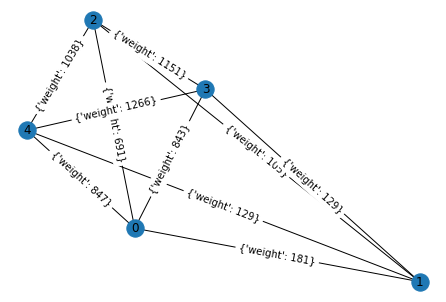

In [3]:
# Generate sample data

G = generate_data(n_unimp, n_imp)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos)
plt.show()

In [4]:
# Get a matrix representation of the problem and use Brute force to obtain the optimal solution

weights = get_weight_matrix(G)  # Obtain the weight matrix

R = compute_normalization_scale(weights)  # The normalization scale suggested by the paper

rescaled_weights = weights / R  # The rescaled weight matrix

cost_of_graph, partition = brut_force(G,k)  # Uses brute force to find the optimal solution, so that we have a reference 
                                   # to test our algorithm
    
normalized_cost = cost_of_graph / R


print('original weight matrix =', weights)
print('normalization factor =', R)
print('rescaled weight matrix =', rescaled_weights)
print('original cost =', cost_of_graph)
print('normalized cost =', normalized_cost)

original weight matrix = [[   0  181  691  843  847]
 [ 181    0  105  129  129]
 [ 691  105    0 1151 1038]
 [ 843  129 1151    0 1266]
 [ 847  129 1038 1266    0]]
normalization factor = 7912.5
rescaled weight matrix = [[0.         0.0228752  0.08733017 0.10654028 0.10704581]
 [0.0228752  0.         0.01327014 0.01630332 0.01630332]
 [0.08733017 0.01327014 0.         0.14546603 0.13118483]
 [0.10654028 0.01630332 0.14546603 0.         0.16      ]
 [0.10704581 0.01630332 0.13118483 0.16       0.        ]]
original cost = 6275
normalized cost = 0.7930489731437599


In [5]:
param_history, cost_history, circ_history = full_optimization_loop(n, l, rescaled_weights, p, 
                                                                   local_optimization_method=local_optimization_method, 
                                                                   optimal_cost=normalized_cost)

1st params [-0.16257574  7.01581991]
1st cost 0.6615787914691937
2nd iteration (EGG), params [-0.16257574 -1.72207287  7.01581991 11.32022416]
2nd iteration (EGG),  cost 0.6781301836492873
2nd iteration (Nelder-Mead), params [-0.16129371 -1.7385116   7.17973934 11.33846475]
2nd iteration (Nelder-Mead), cost 0.681829087677723
3th iteration (EGG), params [-0.16129371 -1.7385116  -0.11132338  7.17973934 11.33846475 10.5947037 ]
3th iteration (EGG),  cost 0.684087677725118
3th iteration (Nelder-Mead), params [-0.16659387 -1.74392402 -0.11054136  7.23616082 11.30857328 10.67907519]
3th iteration (Nelder-Mead), cost 0.6906375888625588
Approximation Ratio Evolution  [0.83422186 0.85509244 0.8597566  0.86260458 0.87086373]


In [6]:
param_history

[array([-0.16257574,  7.01581991]),
 array([-0.16257574, -1.72207287,  7.01581991, 11.32022416]),
 array([-0.16129371, -1.7385116 ,  7.17973934, 11.33846475]),
 array([-0.16129371, -1.7385116 , -0.11132338,  7.17973934, 11.33846475,
        10.5947037 ]),
 array([-0.16659387, -1.74392402, -0.11054136,  7.23616082, 11.30857328,
        10.67907519])]

In [7]:
cost_history

[0.6615787914691937,
 0.6781301836492873,
 0.681829087677723,
 0.684087677725118,
 0.6906375888625588]

In [8]:
#circ_history[-1].decompose().draw()

In [9]:
circ = make_full_circuit(n,l,rescaled_weights,p)  # building the full circuit
counts, transpiled_circ = run_circuit(circ, param_history[-1], nshots=nshots)  # do a final run with optimal parameters found
show_distribution(counts, l)

{'[[0], [1], [2, 3], [4]]': 106,
 '[[0], [1, 3], [2], [4]]': 81,
 '[[0, 1, 2], [3], [4]]': 10,
 '[[0], [1], [2], [3, 4]]': 54,
 '[[0, 1], [2, 4], [3]]': 7,
 '[[0, 3], [1, 2], [4]]': 5,
 '[[0], [1], [2, 3, 4]]': 4,
 '[[0, 2], [1, 3], [4]]': 6,
 '[[0, 2], [1], [3], [4]]': 9,
 '[[0, 4], [1, 2, 3]]': 2,
 '[[0, 3], [1], [2], [4]]': 78,
 '[[0, 2, 4], [1], [3]]': 4,
 '[[0, 2, 3], [1], [4]]': 5,
 '[[0, 4], [1], [2], [3]]': 4,
 '[[0, 2], [1], [3, 4]]': 9,
 '[[0, 2], [1, 4], [3]]': 17,
 '[[0], [1, 2], [3], [4]]': 4,
 '[[0, 3], [1, 4], [2]]': 7,
 '[[0, 4], [1, 2], [3]]': 3,
 '[[0, 3, 4], [1], [2]]': 2,
 '[[0, 1], [2], [3], [4]]': 11,
 '[[0, 1, 2], [3, 4]]': 2,
 '[[0], [1, 2, 3], [4]]': 2,
 '[[0], [1], [2, 4], [3]]': 12,
 '[[0, 1], [2, 3], [4]]': 7,
 '[[0, 1, 2, 4], [3]]': 6,
 '[[0, 1], [2], [3, 4]]': 4,
 '[[0], [1, 3, 4], [2]]': 6,
 '[[0, 1, 2, 3, 4]]': 1,
 '[[0, 2, 4], [1, 3]]': 2,
 '[[0, 1, 3, 4], [2]]': 3,
 '[[0, 4], [1, 3], [2]]': 4,
 '[[0, 1, 3], [2], [4]]': 2,
 '[[0], [1, 4], [2], [3]]': 7,

## Algorithm broke into parts

### Build the circuit

In [10]:
mb = make_mixing_block(n,l,1)  # building the mixing block
#mb.draw()

In [11]:
cb = make_cost_block(n,l,rescaled_weights,1)  # building the cost block 
#cb.draw()

In [12]:
ib = make_initial_block(n,l)  # building the initialization block
#ib.draw()

In [13]:
circ = make_full_circuit(n,l,rescaled_weights,p)  # building the full circuit
#circ.decompose().draw()

### Run a sample circuit

In [14]:
counts, transpiled_circ = run_circuit(circ, init_params, nshots=nshots)  # visualize the circuit to be runned
transpiled_circ.decompose().draw()

C:\Users\Jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\sympy\core\expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


global phase: 2.246
         ┌─────────┐                                                        »
    q_0: ┤ U2(0,π) ├──■───────────────────────────────────■─────────■───────»
         ├─────────┤  │                                   │       ┌─┴─┐     »
    q_1: ┤ U2(0,π) ├──┼────■──────────────────────────────┼────■──┤ X ├──■──»
         ├─────────┤┌─┴─┐  │  ┌────────────────────────┐┌─┴─┐  │  └───┘┌─┴─┐»
    q_2: ┤ U2(0,π) ├┤ X ├──┼──┤ U1(0.0359322761642814) ├┤ X ├──┼───────┤ X ├»
         ├─────────┤└───┘┌─┴─┐├────────────────────────┤└───┘┌─┴─┐     └───┘»
    q_3: ┤ U2(0,π) ├─────┤ X ├┤ U1(0.0359322761642814) ├─────┤ X ├──────────»
         ├─────────┤     └───┘└────────────────────────┘     └───┘          »
    q_4: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         ├─────────┤                                                        »
    q_5: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         ├─────────┤                                                        »
    q_6: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         ├─────────┤                                                        »
    q_7: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         ├─────────┤                                                        »
    q_8: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         ├─────────┤                                                        »
    q_9: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         └─────────┘                                                        »
meas: 10/═══════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                 »
«    q_0: ───────────────────────────────────────────■────■───────»
«                                                  ┌─┴─┐  │       »
«    q_1: ──────────────────────────────────────■──┤ X ├──┼────■──»
«                                             ┌─┴─┐└───┘  │    │  »
«    q_2: ──■──────────────────────────────■──┤ X ├───────┼────┼──»
«         ┌─┴─┐┌────────────────────────┐┌─┴─┐└───┘       │    │  »
«    q_3: ┤ X ├┤ U1(0.0359322761642814) ├┤ X ├────────────┼────┼──»
«         └───┘└────────────────────────┘└───┘          ┌─┴─┐  │  »
«    q_4: ──────────────────────────────────────────────┤ X ├──┼──»
«                                                       └───┘┌─┴─┐»
«    q_5: ───────────────────────────────────────────────────┤ X ├»
«                                                            └───┘»
«    q_6: ────────────────────────────────────────────────────────»
«                                                                 »
«    q_7: ────────────────────────────────────────────────────────»
«                                                                 »
«    q_8: ────────────────────────────────────────────────────────»
«                                                                 »
«    q_9: ────────────────────────────────────────────────────────»
«                                                                 »
«meas: 10/════════════════════════════════════════════════════════»
«                                                                 »
«                                                           »
«    q_0: ───────────────────────────■─────────■────────────»
«                                    │       ┌─┴─┐          »
«    q_1: ───────────────────────────┼────■──┤ X ├──■───────»
«                                    │    │  └───┘  │       »
«    q_2: ───────────────────────────┼────┼─────────┼───────»
«                                    │    │         │       »
«    q_3: ───────────────────────────┼────┼─────────┼───────»
«         ┌───────────────────────┐┌─┴─┐  │       ┌─┴─┐     »
«    q_4: ┤ U1(0.137177916185185) ├┤ X ├──┼───────┤ X ├──■──»
« 

In [15]:
average_cost = compute_cost(counts, l, rescaled_weights, n_counts = nshots)  # compute the cost from the sample run 
                                                                             # above
average_cost

0.4844480647709339

### Run QAOA with only a local optimization algorithm 

In [16]:
func_to_optimize = func_to_optimize_wrapper(circ, l, rescaled_weights, nshots=512, simulator='aer_simulator')

In [17]:
res = minimize(func_to_optimize, init_params, method=local_optimization_method)
print('cost', -1*res.fun)
print('approximation_ratio', -1*res.fun / normalized_cost)
print('parameters', res.x)

cost 0.5511754541864153
approximation_ratio 0.6950080926294838
parameters [0.41075637 3.3772473  0.37885023 3.13304698 0.37962712 3.20312316]


# Benchmarking

In [18]:
distribution_qaoa = show_distribution(counts, l)

In [19]:
counts_accept=nshots*0.05
len_d = len(distribution_qaoa.values())

In [20]:
Prob_distribution = dict()
for key, value in distribution_qaoa.items():
    if value > counts_accept:
        Prob_distribution[key]=value

In [21]:
import ast

In [22]:
for key, value in Prob_distribution.items():
    P = {}
    participation_data = ast.literal_eval(key)  
    for i in range(len(participation_data)):
        P["P"+str(i)] = participation_data[i]
    a,b = cost(G, P)

# Key muss array sein, kein string

TypeError: cannot unpack non-iterable numpy.int32 object

In [ ]:

print(partition)